In [ ]:
!pip install transformers datasets tqdm openpyxl -q

The command installs the Python packages transformers, datasets, tqdm, and openpyxl using pip, with quiet mode turned on. You would use it to set up an environment workflow for NLP tasks, dataset things, progress bars, and Excel files- it is straightforward as a single simple shell command. The strengths are that it can install multiple packages quickly and directly. The weaknesses are that there is not version pinning and it lacks error handling, which is an issue for reproducibility.

In [ ]:
import os, re, time, random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    set_seed
)

import matplotlib.pyplot as plt
from IPython.display import FileLink, display

This block brings in modules for system functions, data handling, tracking progress, PyTorch into low-level modeling and optimization, scikit-learn for preprocessing and metrics, transformers for models and tokenizers, and plotting. The structure of this block is grouped by these libraries purely for clarity. The logic prepares a complete workflow for using NLP classification from training, testing, and visualization. The strengths of this block are eventually the coverage of tools needed. The weakness of this block is that it has a heavy dependency with no lazy imports to postpone the startup loads to the user.


In [ ]:
IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    print("Running in Google Colab ")
except ImportError:
    print("Not running in Colab (local/Jupyter environment).")

SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {DEVICE}")


Running in Google Colab 
 Using device: cuda


This code block detects whether the code is running in Google Colab and sets a flag, tries to mount Colab drive if it's available, then sets a fixed random seed for the Python, NumPy, PyTorch CPU, PyTorch GPU, and transformers libraries, as well as selects the device that can be used for the computations. Structure follows a try-except for the environment detection, followed by sequential seed and device setup. The logic is aimed at reproducibility and consistent device usage. Strengths are that it sets a seed for everything, and clearly defines the device. Weaknesses are that it does not set deterministic cuDNN settings, nor does it provide fallback options for partially running Colab

In [ ]:

MODEL_NAME   = "distilbert-base-uncased"
EPOCHS       = 4
LR           = 3e-5
MAX_LEN      = 256
BATCH_SIZE   = 16
WEIGHT_DECAY = 0.03
WARMUP_RATIO = 0.06
LOGGING_STEPS = 200

print("\n Training Configuration")
print(f"MODEL_NAME   = {MODEL_NAME}")
print(f"EPOCHS       = {EPOCHS}")
print(f"LR           = {LR}")
print(f"MAX_LEN      = {MAX_LEN}")
print(f"BATCH_SIZE   = {BATCH_SIZE}")
print(f"WEIGHT_DECAY = {WEIGHT_DECAY}")
print(f"WARMUP_RATIO = {WARMUP_RATIO}")



 Training Configuration
MODEL_NAME   = distilbert-base-uncased
EPOCHS       = 4
LR           = 3e-05
MAX_LEN      = 256
BATCH_SIZE   = 16
WEIGHT_DECAY = 0.03
WARMUP_RATIO = 0.06


This block defines important hyperparameters for training a transformer model including, model_name, num_epochs, learning_rate, max_seq_length, batch_size, weight_decay, warmup_ratio, and log_frequency, and then displays them to verify their values. The code structure consists of direct assignments followed by formatted output. Within this block, logic is contained to ensure the training conditions are the same and just as easily as inspection prior to running a training session. In terms of strengths, this code block clearly defines each parameter in variable assignments, and manages all hyperparameter settings from one place. In terms of weaknesses, parameters are hardcoded and there is no inspection of parameters range values.

In [ ]:
FULL_DATA_FILE = "phishing_emails_dataset.csv"
TRAINVAL_FILE  = "phishing_emails_trainval.csv"
TEST_FILE      = "phishing_emails_test.csv"

if not os.path.exists(TRAINVAL_FILE) or not os.path.exists(TEST_FILE):
    if not os.path.exists(FULL_DATA_FILE):
        if IN_COLAB:
            print("\n phishing_emails_dataset.csv not found. Please upload it.")
            from google.colab import files
            uploaded = files.upload()
            FULL_DATA_FILE = list(uploaded.keys())[0]
        else:
            raise FileNotFoundError(
                f"{FULL_DATA_FILE} not found in current directory: {os.listdir('.')}"
            )

    full_df = pd.read_csv(FULL_DATA_FILE)
    print(f"\n Loaded full dataset {FULL_DATA_FILE}, shape = {full_df.shape}")

    trainval_df, test_df = train_test_split(
        full_df,
        test_size=0.2,
        random_state=SEED,
        stratify=full_df["label"]
    )

    trainval_df.to_csv(TRAINVAL_FILE, index=False)
    test_df.to_csv(TEST_FILE, index=False)

    print("\nCreated split:")
    print("  Train+Val ->", trainval_df.shape, "saved as", TRAINVAL_FILE)
    print("  Test      ->", test_df.shape,      "saved as", TEST_FILE)
else:
    print(f"\nFound existing split files: {TRAINVAL_FILE}, {TEST_FILE}")


 phishing_emails_dataset.csv not found. Please upload it.


Saving phishing_emails_dataset.csv to phishing_emails_dataset.csv

 Loaded full dataset phishing_emails_dataset.csv, shape = (10000, 8)

Created split:
  Train+Val -> (8000, 8) saved as phishing_emails_trainval.csv
  Test      -> (2000, 8) saved as phishing_emails_test.csv


This block checks for pre-split training and testing CSV files, initiates a Colab upload if no full dataset exists, reads the full dataset into a DataFrame, runs an 80/20 stratified split for train+validation and test splits, saves the splits to CSV, and prints out the shape of the splits. The logic is organized in that it first checks if the datasets exist, then reads data in, splits it appropriately, and then saves that data down. The logic has been designed to produce a consistent dataset with the advantage of reproducibility given a fixed seed. The primary strength of this block of code is the automatic splitting and the ease in file management. The primary weakness of this code block is the total reliance on a fixed column name for target labels and it does not check prior to uploading, the contents of uploaded data.

In [ ]:
DATA_FILE = TRAINVAL_FILE

df = pd.read_csv(DATA_FILE)
print(f"\n Loaded train+val data {DATA_FILE}, shape = {df.shape}")
print(df.head())

df.rename(columns=lambda x: x.strip().lower(), inplace=True)

text_cols = [c for c in df.columns
             if c in ["subject", "body", "text", "content", "message"]]
if not text_cols:
    raise ValueError(
        f"No valid text columns found. Got columns: {df.columns.tolist()}"
    )

df["text"] = df[text_cols].fillna("").astype(str).agg(" ".join, axis=1)

if "label" not in df.columns:
    raise ValueError("Dataset must contain a 'label' column.")

df["label"] = df["label"].replace({"phishing": 1, "legitimate": 0}).astype(int)

print("\n🔢 Label distribution (train+val original):")
print(df["label"].value_counts())


 Loaded train+val data phishing_emails_trainval.csv, shape = (8000, 8)
         id                         from               to  \
0  6cacd32a  pougalhqxu@students.jru.edu    admin@jru.edu   
1  f5c10745        nlqatwaxw@outlook.com  student@jru.edu   
2  2c4a1af8     peulhtroekco@outlook.com  support@jru.edu   
3  3ee65271         kghubnondn@yahoo.com  faculty@jru.edu   
4  485f8a29         ojafhhenrz@gmail.com    admin@jru.edu   

                                subject  \
0    Account Suspended: Action Required   
1           Payment Confirmation Failed   
2          Invoice and Payment Received   
3  Classroom Schedule Adjustment Notice   
4    Urgent: Update Billing Information   

                                                body  \
0  Your payment could not be processed. Click the...   
1  Please reset your password now to secure your ...   
2  Please be informed that your class schedule ha...   
3  This is to acknowledge your successful payment...   
4  Our system shows an

In this section, it will perform steps to load the train+validation CSV to a DataFrame, normalize the column names, encode the valid text columns, combine the valid columns into a single text column, check for a label column, convert the labels to integers, and print counts of the labels. The steps are sequenced together for consistency so that all checks all layer together through the transformations. This sequence makes sure a clean specifically labeled text data set can be made for reliable preparation in model fitting. The strength of this section is the confident validations and standardized preprocesses. The weaknesses are that the model fits a specific set group of text columns, and does not identify unforeseen label values.

In [ ]:
def clean_text(t: str) -> str:
    t = str(t).lower()
    t = re.sub(r"<[^>]+>", " ", t)
    t = re.sub(r"http\S+|www\.\S+", " [URL] ", t)
    t = re.sub(r"\S+@\S+", " [EMAIL] ", t)
    t = re.sub(r"[^a-z\s\[\]]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

tqdm.pandas(desc="Cleaning text")
df["clean_text"] = df["text"].progress_apply(clean_text)

maj = df[df.label == 0]
mino = df[df.label == 1]

if len(maj) != len(mino):
    mino_up = resample(
        mino,
        replace=True,
        n_samples=len(maj),
        random_state=SEED
    )
    df_bal = pd.concat([maj, mino_up]).drop_duplicates(
        subset=["clean_text"]
    ).reset_index(drop=True)
    print("\nAfter balancing:")
else:
    df_bal = df.copy()
    print("\nData already balanced:")

print(df_bal["label"].value_counts())


Cleaning text: 100%|██████████| 8000/8000 [00:01<00:00, 5002.88it/s]



After balancing:
label
0    369
1    203
Name: count, dtype: int64


This code block is defining a function that sanitizes text, which lowercases it, eliminates the HTML, replaces URLs in the text with "http://address.url" and emails with  "email@address.com", removes characters that aren't letters, and collapses whitespace, and makes use of the function in the data set with a progress bar. The function separates the possible majority and minority classes, upsamples the minority class, removes duplicate texts, and prints the counts of the resulting labels. The code is structured to do text preprocessing and then balancing sequentially. The implementation maintains that a clean and balanced input is available for training model usage. The strengths are the text will always be normalized via the function and the minority class will always be balanced with upsampling. The weakness is that the program does not design to handle texts that are extremely long or that have unusual characters not handled by the given regex.

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_bal["clean_text"],
    df_bal["label"],
    test_size=0.2,
    random_state=SEED,
    stratify=df_bal["label"]
)

print(f"\nSplit sizes -> Train: {len(train_texts)}, Val: {len(val_texts)}")


Split sizes -> Train: 457, Val: 115


This block takes in a balanced data set and splits it into training and validation sets, with an 80/20 stratified split for the two sets. This implies the proportions remain the same between sets. The training and validation splits store both the text and labels separately for each set. The block also restores the sizes of the training and validation set splits. The structure of this block can be represented as a single call to scikit-learn's train_test_split method. The logic guides to always produce reproducible stratified splits for model training and evaluation. The benefits of this block are a reproducible stratified split for model training and evaluation, and preserving class balance. The cons consist of no checks for too small of a classes or a small number of samples.

In [ ]:
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].flatten(),
            "attention_mask": enc["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = EmailDataset(train_texts, train_labels, tokenizer, max_len=MAX_LEN)
val_ds   = EmailDataset(val_texts,   val_labels,   tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

print(f"\nDataLoaders ready: {len(train_loader)} train batches, {len(val_loader)} val batches")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


DataLoaders ready: 29 train batches, 8 val batches


This code defines a Dataset class in PyTorch that tokenizes email text - including padding and truncation - and returns input tensors and labels. Specifically, it loads a tokenizer for the appropriate model/unrestricted model, creates training and validation instances of the Dataset class, wraps the Dataset instances in DataLoaders with batching on, shuffling if indicates, and prints the number of batches. The main difference in a Dataset versus the standard DataLoader module structure is that it keeps the dataset loading logic separate. The logic also packs the inputs in a way compatible with training and evaluating different models by creating attention masks. Strengths of the overall structure are modularity and the compatibility with transformer-based models. Weaknesses of the dataset module are its fixed maximum length and that it lacks a dynamic padding mode (for text inputs) that is efficient.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print("\nModel, optimizer, and scheduler initialized.")
print(f"Total steps: {total_steps}, Warmup steps: {warmup_steps}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model, optimizer, and scheduler initialized.
Total steps: 116, Warmup steps: 6


This block initializes a transformer sequence classification model with two labels, moves it to the selected device, sets up an AdamW optimizer with learning rate and weight decay, calculates total training steps and warmup steps, and prepares linear learning rate scheduling with warmup. It is organized such that model, optimizer, and scheduler are setup separately. In regard to logic, it maintains normal training dynamics with a linearly increasing learning rate at the ramp-up period of training. It also has a few weaknesses for example no gradient clipping. Additionally, the optimizer has no device aware settings beyond what is done when it is placed on the model's device.

In [ ]:
def train_epoch(model, data_loader, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    all_labels, all_preds = [], []

    loop = tqdm(data_loader, desc="Training", leave=False)
    for step, batch in enumerate(loop, start=1):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)
        labels    = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids,
            attention_mask=attn_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=-1).detach().cpu().numpy()
        true  = labels.detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(true)

        if step % LOGGING_STEPS == 0:
            loop.set_postfix(loss=loss.item())
            print(f"  Step {step}/{len(data_loader)} - loss: {loss.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average="weighted")

    return avg_loss, acc, f1


def eval_epoch(model, data_loader):
    model.eval()
    total_loss = 0.0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validation", leave=False):
            input_ids = batch["input_ids"].to(DEVICE)
            attn_mask = batch["attention_mask"].to(DEVICE)
            labels    = batch["labels"].to(DEVICE)

            outputs = model(
                input_ids,
                attention_mask=attn_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = logits.argmax(dim=-1).detach().cpu().numpy()
            true  = labels.detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(true)

    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average="weighted")
    report = classification_report(all_labels, all_preds, digits=4)
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, acc, f1, report, cm

This set of functions encapsulates the training and evaluation of models within the epoch level. In the training function, the switch to training mode is made, a loop is established for batches, loss and logits are calculated, backpropagation occurs, and the optimizer and scheduler are updated, and predictions are collected all within a batch, and returns average loss, accuracy, and weighted F1. In the evaluation function, the model goes to eval mode, is forced with no gradients, and once again a loop is established over the batches to determine loss and predictions, and returns aggregated average loss, accuracy, weighted F1, a classification report, and a confusion matrix. Structurally, separate training and evaluation imports clean batching level operations. The design provides for the ability for gradient updates, to metric over cycles, and safe inference as necessary. Strengths include a flexible batch structure, encapsulation of metrics, and keeping track of epochs. Weaknesses include no early stopping, gradient clipping, and no mixed precision.

In [ ]:
best_val_f1 = 0.0
best_report = None
best_cm = None
history = []

print("\n========== Fine-tuning Transformer ==========")
for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch + 1}/{EPOCHS} =====")
    start_t = time.time()

    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, optimizer, scheduler
    )
    val_loss, val_acc, val_f1, val_report, val_cm = eval_epoch(
        model, val_loader
    )

    elapsed = time.time() - start_t

    history.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
        "time_sec": elapsed,
    })

    print(f"\n[Train] loss={train_loss:.4f} acc={train_acc:.4f} f1={train_f1:.4f}")
    print(f"[Val]   loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}")
    print(f"Epoch time: {elapsed:.1f} sec")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_report = val_report
        best_cm = val_cm
        torch.save(model.state_dict(), "best_model_state.bin")
        print(" New best model saved with F1 =", best_val_f1)


========== Fine-tuning Transformer ==========

===== Epoch 1/4 =====



[Train] loss=0.4079 acc=0.8074 f1=0.8057
[Val]   loss=0.1430 acc=0.9391 f1=0.9393
Epoch time: 11.2 sec
 New best model saved with F1 = 0.9392900795729502

===== Epoch 2/4 =====



[Train] loss=0.1243 acc=0.9453 f1=0.9453
[Val]   loss=0.0930 acc=0.9739 f1=0.9740
Epoch time: 10.2 sec
 New best model saved with F1 = 0.9739814626741216

===== Epoch 3/4 =====



[Train] loss=0.0733 acc=0.9716 f1=0.9715
[Val]   loss=0.0713 acc=0.9652 f1=0.9654
Epoch time: 10.4 sec

===== Epoch 4/4 =====



[Train] loss=0.0554 acc=0.9759 f1=0.9758
[Val]   loss=0.0645 acc=0.9652 f1=0.9652
Epoch time: 10.6 sec


The code is a fine-tuned Transformer model that monitors its performance on a per-epoch basis. It sets the variables to optimize the validation F1-score, report and the confusion matrix and maintains a history of training. The loop is repeated by a certain number of epochs. Every iteration then trains the model with train epoch, evaluates it with evaluation epoch and also time is measured. It records such important metrics as loss, accuracy and F1-score of both training and validation. A new optimal validation F1-score is reached, which is stored in disk. Its strengths are evident progress tracking, automatic saving of best models and decent metric reporting. Potential weaknesses are that early stopping must be added, and that in long term behavior, it can overfit, and may have a memory accumulation in the case of large history.

In [ ]:
print("\n========== BEST VALIDATION RESULTS ==========")
print(f"Best val F1: {best_val_f1:.4f}")
print("\nClassification report (best epoch):\n")
print(best_report)
print("Confusion matrix (best epoch):")
print(best_cm)

hist_df = pd.DataFrame(history)
hist_df.to_excel("training_history_final.xlsx", index=False)
print("\nSaved training history to training_history_final.xlsx")

SAVE_DIR = "final_bert_phishing"
os.makedirs(SAVE_DIR, exist_ok=True)
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print(f"Saved model & tokenizer to folder: {SAVE_DIR}")

print("\nFiles in current directory now:")
print(os.listdir("."))


========== BEST VALIDATION RESULTS ==========
Best val F1: 0.9740

Classification report (best epoch):

              precision    recall  f1-score   support

           0     0.9863    0.9730    0.9796        74
           1     0.9524    0.9756    0.9639        41

    accuracy                         0.9739       115
   macro avg     0.9693    0.9743    0.9717       115
weighted avg     0.9742    0.9739    0.9740       115

Confusion matrix (best epoch):
[[72  2]
 [ 1 40]]

Saved training history to training_history_final.xlsx
Saved model & tokenizer to folder: final_bert_phishing

Files in current directory now:
['.config', 'phishing_emails_trainval.csv', 'phishing_emails_dataset.csv', 'final_bert_phishing', 'best_model_state.bin', 'phishing_emails_test.csv', 'training_history_final.xlsx', 'sample_data']


This code summarizes best validation results, exports training history and saves final model. It then prints the best validation F1-score, and the printed classification report and confusion matrix and converts the training history to a dataframe and stores it to an Excel file to be examined later. It makes a train folder of the final model, stores the model weights and the tokenizer files and enumerates the contents of the directory so that you can check the outputs. Clearly reported results and sound persistence of artifacts are some of the strengths. One of the weaknesses is that the code presupposes the report and confusion matrix objects are never absent, which may not work in the case when no epoch raises the score.

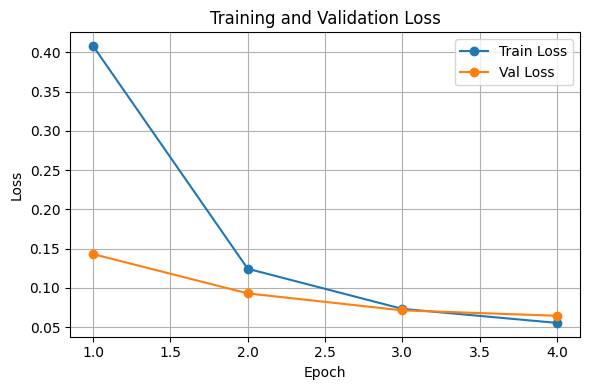

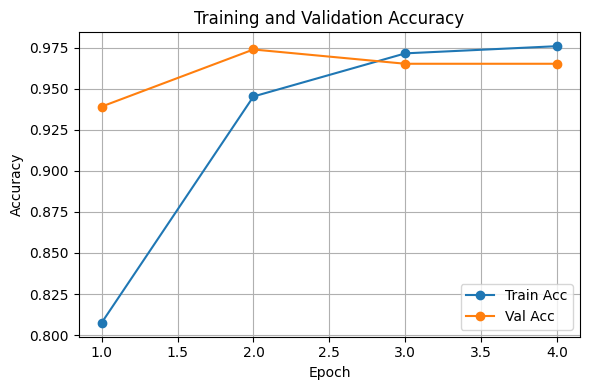

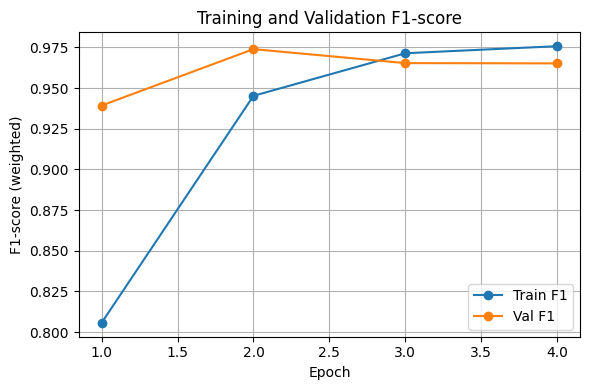

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(hist_df["epoch"], hist_df["train_loss"], marker="o", label="Train Loss")
plt.plot(hist_df["epoch"], hist_df["val_loss"],   marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_df["epoch"], hist_df["train_acc"], marker="o", label="Train Acc")
plt.plot(hist_df["epoch"], hist_df["val_acc"],   marker="o", label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_df["epoch"], hist_df["train_f1"], marker="o", label="Train F1")
plt.plot(hist_df["epoch"], hist_df["val_f1"],   marker="o", label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1-score (weighted)")
plt.title("Training and Validation F1-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This code produces three line plots, each of which monitors the performance of the models with regard to epochs. Training and validation loss, accuracy, and F1-score are plotted with the help of the values in the history dataframe. There are clear labels, markers, titles, grid lines and tight layout to enhance the readability in each plot. The algorithm is very basic: load columns with the metrics, plot and present the figure. Among the strengths, one has the ability to visualize and easily compare the training and validation trends. The repeated plotting code is also a weakness, and it would be better to use a helper function to minimize redundancy.

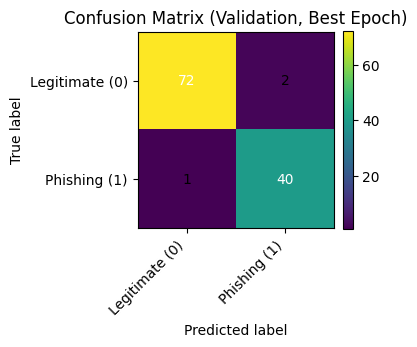

In [ ]:
cm = np.array(best_cm)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation, Best Epoch)")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(2)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(["Legitimate (0)", "Phishing (1)"], rotation=45, ha="right")
ax.set_yticklabels(["Legitimate (0)", "Phishing (1)"])
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


This code plots your optimal confusion matrix to assist you to investigate classification conduct amidst two classes. It loads the matrix, plots it using the imshow command, adds labels to legitimate and phishing emails to the plot and annotates each cell with the count of the validity using contrasting text colors. It also determines axis ticks, draws a color bar and makes a threshold that is used to select readable text colors. Class strengths are appropriate labeling and interpretation of errors. One weakness is the naming of classes that are fixed and, therefore, cannot be reused by tasks with more than two categories.

In [ ]:
print("\nZipping artifacts for download...")

os.system("zip -r final_bert_phishing.zip final_bert_phishing > /dev/null")
os.system(
    "zip -r submission_bundle.zip final_bert_phishing "
    "training_history_final.xlsx phishing_emails_trainval.csv phishing_emails_test.csv "
    "> /dev/null"
)

print("Files in directory after zipping:")
print(os.listdir("."))

for fname in ["final_bert_phishing.zip", "submission_bundle.zip"]:
    if os.path.exists(fname):
        print(f" Created: {fname}")
    else:
        print(f" ERROR: {fname} was not created. Check source files/folders.")

if IN_COLAB:
    from google.colab import files
    print("\n Triggering downloads in Colab...")
    files.download("final_bert_phishing.zip")
    files.download("submission_bundle.zip")
else:
    print("\n Not in Colab. Use these links to download the ZIPs:")
    display(FileLink("final_bert_phishing.zip"))
    display(FileLink("submission_bundle.zip"))



Zipping artifacts for download...
Files in directory after zipping:
['.config', 'final_bert_phishing.zip', 'phishing_emails_trainval.csv', 'phishing_emails_dataset.csv', 'final_bert_phishing', 'best_model_state.bin', 'phishing_emails_test.csv', 'training_history_final.xlsx', 'submission_bundle.zip', 'sample_data']
 Created: final_bert_phishing.zip
 Created: submission_bundle.zip

 Triggering downloads in Colab...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This code bundles your model artifacts, verifies the ZIP results and downloads are made ready to other environments. The model folder, training history Excel file and train or test CSV files are then added to a new folder (submission_bundle.zip) and zip it with the windows operating system command, which silences the output of the command (=> iteration of the process). Upon zip, the code will print all the contents of the directory and repeat through the anticipated zip name names to ensure that files are created by printing a message of success or message of error. It is then followed by a conditional block which will import and use Google.colab.files if required and then call files.download in both the Colab and non Colab paths where a call to FileLink objects would display download links. The strengths are automated packaging, simple validation of results and both Colab and local environment support. Examples of the weaknesses are that it relies on the external zip commands through the shell and that it depends on predefined file names thereby limiting the flexibility of this option in case of changing paths or filenames.